# About this notebook
- tokenizer(anchor[SEP]target | CPC)
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

# Directory settings

In [1]:
# ====================================================
# Directory settings
# ====================================================
comp_name = 'us-patent-phrase-to-phrase-matching'
nb_name = 'nb005t-deberta-v3-large'

import sys
print(sys.version)
if "google.colab" in sys.modules:
    from google.colab import drive
    drive.mount("/content/drive")
    base = f"/content/drive/MyDrive/colab_notebooks/kaggle/{comp_name}/notebooks"
    %cd {base}


import os
INPUT_DIR = f'../input/{comp_name}/'
if 'kaggle_web_client' in sys.modules:
    OUTPUT_DIR = './'
else:
    OUTPUT_DIR = f'../input/{nb_name}/'
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)

3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/colab_notebooks/kaggle/us-patent-phrase-to-phrase-matching/notebooks


# CFG

In [2]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug=False
    wandb=True
    wandbproject=comp_name
    wandbgroup=nb_name
    wandbname='exp003.002'
    _wandb_kernel='riow1983'
    apex=True
    print_freq=100
    num_workers=8
    model="microsoft/deberta-v3-large"
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=4
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    batch_size=16
    fc_dropout=0.2
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    #### AWP
    adv_lr=1e-6
    adv_eps=1e-3
    #### AWPAWP
    n_fold=10
    trn_fold=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    train=True
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]
    CFG.wandb = False

In [3]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    if 'google.colab' in sys.modules:
        !pip install wandb
    import wandb

    try:
        if 'kaggle_web_client' in sys.modules:
            from kaggle_secrets import UserSecretsClient
            user_secrets = UserSecretsClient()
            secret_value_0 = user_secrets.get_secret("wandb_api")
        else:
            import json
            f = open("../../wandb.json", "r")
            json_data = json.load(f)
            secret_value_0 = json_data["wandb_api"]
        wandb.login(key=secret_value_0)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))
    
    run = wandb.init(
        dir=OUTPUT_DIR,
        project=CFG.wandbproject,
        group=CFG.wandbgroup,
        name=CFG.wandbname, 
        config=class2dict(CFG),
        job_type="train",
        anonymous=anony)
    print(f"wandb run id: {run.id}")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 15.1 MB/s 
     |████████████████████████████████| 181 kB 72.7 MB/s 
     |████████████████████████████████| 145 kB 69.7 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=043c0a1838e0e021a714bce031d383df8f9754a0cb965141d7dd3c18e29f2925
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: riow1983. Use `wandb login --relogin` to force relogin


wandb run id: kci59mo9


# Library

In [4]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold


# # PyTorchのバージョンを1.10.1に下げる (Google Colabなのでpipでやる)
# os.system('pip uninstall -y torch torchvision torchaudio')
# os.system('pip install torch==1.10.1+cu111 torchvision==0.11.2+cu111 torchaudio==0.10.1 -f https://download.pytorch.org/whl/torch_stable.html')


import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

os.system('pip uninstall -y transformers')
os.system('pip uninstall -y tokenizers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels transformers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels tokenizers')
# os.system('python -m pip install transformers')
# os.system('python -m pip install tokenizers')
os.system('pip install sentencepiece')
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.11.0+cu113
tokenizers.__version__: 0.12.1
transformers.__version__: 4.18.0
env: TOKENIZERS_PARALLELISM=true


# Utils

In [5]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [6]:
# ====================================================
# Data Loading
# ====================================================
# #### AUG
# # train = pd.read_csv(INPUT_DIR+'train.csv')
# train = pd.read_csv('../input/kagglenb006-back-translate-aug-data/train.csv')
# #### AUGAUG
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [7]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('../input/cpc-data/CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


cpc_texts = get_cpc_texts()
torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [8]:
# train['text'] = train['anchor'] + '[SEP]' + train['target'] + '[SEP]'  + train['context_text']
# test['text'] = test['anchor'] + '[SEP]' + test['target'] + '[SEP]'  + test['context_text']

train['text'] = train['anchor'] + '[SEP]' + train['target']
test['text'] = test['anchor'] + '[SEP]' + test['target']

train['text2'] = train['context_text']
test['text2'] = test['context_text']


display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text,text2
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]abatement of pollution,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]act of abating,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]active catalyst,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]eliminating process,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]forest region,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text,text,text2
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum[SEP]inorganic photoconductor drum,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,adjust gas flow[SEP]altering gas flow,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,lower trunnion[SEP]lower locating,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,cap component[SEP]upper portion,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation[SEP]artificial neural network,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


# EDA

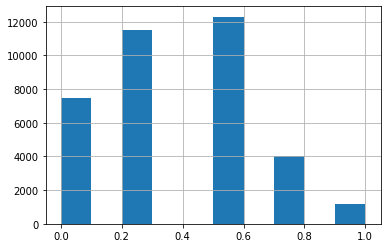

In [9]:
train['score'].hist()

In [10]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [11]:
# ====================================================
# CV split
# ====================================================
# train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
# Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
# for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'])):
#     train.loc[val_index, 'fold'] = int(n)
# train['fold'] = train['fold'].astype(int)
# display(train.groupby('fold').size())


# #### AUG
# aug = train[train['is_aug']==1].reset_index(drop=True)
# train = train[train['is_aug']==0].reset_index(drop=True)
# #### AUGAUG


# Credits to https://www.kaggle.com/code/hannes82/pppm-deberta-v3-large-closing-the-cv-lb-gap/notebook#CV-split
#credits to: https://www.kaggle.com/code/abhishek/creating-folds-properly-hopefully-p

!pip install -q iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

dfx = pd.get_dummies(train, columns=["score"]).groupby(["anchor"], as_index=False).sum()
cols = [c for c in dfx.columns if c.startswith("score_") or c == "anchor"]
dfx = dfx[cols]

mskf = MultilabelStratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=42)
labels = [c for c in dfx.columns if c != "anchor"]
dfx_labels = dfx[labels]
dfx["fold"] = -1

for fold, (trn_, val_) in enumerate(mskf.split(dfx, dfx_labels)):
    print(len(trn_), len(val_))
    dfx.loc[val_, "fold"] = fold

train = train.merge(dfx[["anchor", "fold"]], on="anchor", how="left")
del dfx



# #### AUG
# res = []
# for fold in range(CFG.n_fold):
#     val_ids = train.loc[train['fold']==fold, 'id'].values
#     to_add_aug = aug[~aug['id'].isin(val_ids)].reset_index(drop=True)
#     to_add_aug['fold'] = fold+10
#     res.append(to_add_aug)

# to_add_aug = pd.concat(res, axis=0, ignore_index=True)
# train = pd.concat([train, to_add_aug], axis=0, ignore_index=True)
# del aug, to_add_aug, res, val_ids
# #### AUGAUG

print(train.fold.value_counts())

660 73
660 73
659 74
659 74
660 73
659 74
660 73
660 73
660 73
660 73
0    3954
9    3947
4    3902
6    3647
1    3634
3    3604
2    3524
5    3517
8    3487
7    3257
Name: fold, dtype: int64


In [12]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [13]:
# ====================================================
# tokenizer
# ====================================================
tokenizer = AutoTokenizer.from_pretrained(CFG.model)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Dataset

In [14]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
# CFG.max_len = max(max(lengths_dict['anchor'])+max(lengths_dict['target'])+3, max(lengths_dict['context_text'])+2)
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 133


In [15]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text, text2):
    inputs = cfg.tokenizer(text, text2,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['text'].values
        self.texts2 = df['text2'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item], self.texts2[item])
        #inputs2 = prepare_input(self.cfg, self.texts2[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        #return inputs, inputs2, label
        return inputs, label

In [16]:
"""
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)
"""

'\ntrain_dataset = TrainDataset(CFG, train)\ninputs, label = train_dataset[0]\nprint(inputs)\nprint(label)\n'

# Model

In [17]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        
        # outputs2 = self.model(**inputs2)
        # last_hidden_states2 = outputs2[0]
        
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        #feature2 = torch.mean(last_hidden_states2, dim=1)
        #feature += feature2
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output

# Helpler functions

In [18]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

#### AWP
#def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device, scaler, score, awp):
#### AWPAWP
    model.train()
    # AWP
    #scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    # AWPAWP
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0

    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        # for k, v in inputs2.items():
        #     inputs2[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        #### AWP
        if score > 0.75:
            awp.attack_backward(inputs['input_ids'], labels, inputs['attention_mask'], step) 
        #### AWPAWP

        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        # for k, v in inputs2.items():
        #     inputs2[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        # for k, v in inputs[1].items():
        #     inputs[1][k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [19]:
#### AWP
class AWP:
    def __init__(
        self,
        model,
        optimizer,
        adv_param="weight",
        adv_lr=1,
        adv_eps=0.2,
        start_epoch=0,
        adv_step=1,
        scaler=None
    ):
        self.model = model
        self.optimizer = optimizer
        self.adv_param = adv_param
        self.adv_lr = adv_lr
        self.adv_eps = adv_eps
        self.start_epoch = start_epoch
        self.adv_step = adv_step
        self.backup = {}
        self.backup_eps = {}
        self.scaler = scaler

    def attack_backward(self, x, y, attention_mask,epoch):
        if (self.adv_lr == 0) or (epoch < self.start_epoch):
            return None

        self._save() 
        for i in range(self.adv_step):
            self._attack_step() 
            with torch.cuda.amp.autocast():
                adv_loss, tr_logits = self.model(input_ids=x, attention_mask=attention_mask, labels=y)
                adv_loss = adv_loss.mean()
            self.optimizer.zero_grad()
            self.scaler.scale(adv_loss).backward()
            
        self._restore()

    def _attack_step(self):
        e = 1e-6
        for name, param in self.model.named_parameters():
            if param.requires_grad and param.grad is not None and self.adv_param in name:
                norm1 = torch.norm(param.grad)
                norm2 = torch.norm(param.data.detach())
                if norm1 != 0 and not torch.isnan(norm1):
                    r_at = self.adv_lr * param.grad / (norm1 + e) * (norm2 + e)
                    param.data.add_(r_at)
                    param.data = torch.min(
                        torch.max(param.data, self.backup_eps[name][0]), self.backup_eps[name][1]
                    )
                # param.data.clamp_(*self.backup_eps[name])

    def _save(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad and param.grad is not None and self.adv_param in name:
                if name not in self.backup:
                    self.backup[name] = param.data.clone()
                    grad_eps = self.adv_eps * param.abs().detach()
                    self.backup_eps[name] = (
                        self.backup[name] - grad_eps,
                        self.backup[name] + grad_eps,
                    )

    def _restore(self,):
        for name, param in self.model.named_parameters():
            if name in self.backup:
                param.data = self.backup[name]
        self.backup = {}
        self.backup_eps = {}

#### AWPAWP

In [20]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    
    # #### AUG
    # train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    # train_folds_aug = train_folds[train_folds['fold']==fold+10].reset_index(drop=True)
    # train_folds_base = train_folds[train_folds['fold']<10].reset_index(drop=True)
    # train_folds = pd.concat([train_folds_base, train_folds_aug], axis=0, ignore_index=True)
    # del train_folds_aug, train_folds_base
    # #### AUGAUG
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)

    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values
    
    train_dataset = TrainDataset(CFG, train_folds)
    valid_dataset = TrainDataset(CFG, valid_folds)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.
    #### AWP
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    awp = AWP(model,
              optimizer,
              adv_lr=CFG.adv_lr,
              adv_eps=CFG.adv_eps,
              start_epoch=num_train_steps/CFG.epochs,
              scaler=scaler)
    score = 0.
    #### AWPAWP
    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        #### AWP
        #avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device, scaler, score, awp)
        #### AWPAWP

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [ ]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()




    # Push to LINE
    import requests

    def send_line_notification(message):
        import json
        f = open("../../line.json", "r")
        json_data = json.load(f)
        line_token = json_data["kagglePush"]
        endpoint = 'https://notify-api.line.me/api/notify'
        message = "\n{}".format(message)
        payload = {'message': message}
        headers = {'Authorization': 'Bearer {}'.format(line_token)}
        requests.post(endpoint, data=payload, headers=headers)

    if CFG.wandb:
        send_line_notification(f"Training of {CFG.wandbproject+'/'+CFG.wandbgroup+'/'+CFG.wandbname} has been done. See {run.url}")
    else:
        send_line_notification(f"Training of {CFG.wandbproject+'/'+CFG.wandbgroup+'/'+CFG.wandbname} has been done.")

========== fold: 0 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClas

Epoch: [1][0/2032] Elapsed 0m 0s (remain 31m 27s) Loss: 0.6698(0.6698) Grad: inf  LR: 0.00002000  
Epoch: [1][100/2032] Elapsed 0m 28s (remain 9m 4s) Loss: 0.6561(0.6317) Grad: 39104.2930  LR: 0.00001999  
Epoch: [1][200/2032] Elapsed 0m 56s (remain 8m 30s) Loss: 0.5318(0.6053) Grad: 42619.1445  LR: 0.00001997  
Epoch: [1][300/2032] Elapsed 1m 23s (remain 7m 59s) Loss: 0.5036(0.5919) Grad: 22547.9590  LR: 0.00001993  
Epoch: [1][400/2032] Elapsed 1m 50s (remain 7m 31s) Loss: 0.5313(0.5847) Grad: 51676.2266  LR: 0.00001988  
Epoch: [1][500/2032] Elapsed 2m 18s (remain 7m 2s) Loss: 0.5270(0.5789) Grad: 34631.0430  LR: 0.00001981  
Epoch: [1][600/2032] Elapsed 2m 46s (remain 6m 35s) Loss: 0.6375(0.5752) Grad: 12288.2930  LR: 0.00001973  
Epoch: [1][700/2032] Elapsed 3m 13s (remain 6m 7s) Loss: 0.5512(0.5724) Grad: 23108.1895  LR: 0.00001964  
Epoch: [1][800/2032] Elapsed 3m 41s (remain 5m 39s) Loss: 0.5874(0.5688) Grad: 34548.0195  LR: 0.00001952  
Epoch: [1][900/2032] Elapsed 4m 8s (rema

Epoch 1 - avg_train_loss: 0.5532  avg_val_loss: 0.5627  time: 601s
Epoch 1 - Score: 0.7936
Epoch 1 - Save Best Score: 0.7936 Model


EVAL: [247/248] Elapsed 0m 40s (remain 0m 0s) Loss: 0.6425(0.5627) 
Epoch: [2][0/2032] Elapsed 0m 0s (remain 26m 52s) Loss: 0.4909(0.4909) Grad: 10943.6582  LR: 0.00001707  
Epoch: [2][100/2032] Elapsed 0m 29s (remain 9m 15s) Loss: 0.5726(0.5304) Grad: 92310.3359  LR: 0.00001679  
Epoch: [2][200/2032] Elapsed 0m 56s (remain 8m 38s) Loss: 0.5292(0.5212) Grad: 375729.1250  LR: 0.00001650  
Epoch: [2][300/2032] Elapsed 1m 24s (remain 8m 5s) Loss: 0.5381(0.5236) Grad: 13700.4844  LR: 0.00001620  
Epoch: [2][400/2032] Elapsed 1m 52s (remain 7m 35s) Loss: 0.4737(0.5221) Grad: 93157.9609  LR: 0.00001590  
Epoch: [2][500/2032] Elapsed 2m 19s (remain 7m 6s) Loss: 0.5435(0.5179) Grad: 95634.8594  LR: 0.00001558  
Epoch: [2][600/2032] Elapsed 2m 47s (remain 6m 37s) Loss: 0.4543(0.5173) Grad: 45976.2539  LR: 0.00001525  
Epoch: [2][700/2032] Elapsed 3m 14s (remain 6m 9s) Loss: 0.4035(0.5179) Grad: 197255.7969  LR: 0.00001492  
Epoch: [2][800/2032] Elapsed 3m 42s (remain 5m 41s) Loss: 0.4365(0.5172

Epoch 2 - avg_train_loss: 0.5159  avg_val_loss: 0.5623  time: 602s
Epoch 2 - Score: 0.8069
Epoch 2 - Save Best Score: 0.8069 Model


EVAL: [247/248] Elapsed 0m 40s (remain 0m 0s) Loss: 0.6341(0.5623) 
Epoch: [3][0/2032] Elapsed 0m 0s (remain 27m 6s) Loss: 0.4908(0.4908) Grad: 52965.0352  LR: 0.00001000  
Epoch: [3][100/2032] Elapsed 0m 29s (remain 9m 17s) Loss: 0.4443(0.4990) Grad: 68592.8359  LR: 0.00000961  
Epoch: [3][200/2032] Elapsed 0m 57s (remain 8m 39s) Loss: 0.5058(0.4986) Grad: 106265.0156  LR: 0.00000923  
Epoch: [3][300/2032] Elapsed 1m 24s (remain 8m 6s) Loss: 0.4996(0.4992) Grad: 45386.9180  LR: 0.00000884  
Epoch: [3][400/2032] Elapsed 1m 52s (remain 7m 36s) Loss: 0.4465(0.4955) Grad: 76555.5078  LR: 0.00000846  
Epoch: [3][500/2032] Elapsed 2m 19s (remain 7m 6s) Loss: 0.4766(0.4981) Grad: 102536.6406  LR: 0.00000808  
Epoch: [3][600/2032] Elapsed 2m 47s (remain 6m 38s) Loss: 0.5165(0.4999) Grad: 40773.3359  LR: 0.00000770  
Epoch: [3][700/2032] Elapsed 3m 14s (remain 6m 9s) Loss: 0.4378(0.5009) Grad: 18284.4551  LR: 0.00000733  
Epoch: [3][800/2032] Elapsed 3m 42s (remain 5m 41s) Loss: 0.4710(0.5008)

Epoch 3 - avg_train_loss: 0.5017  avg_val_loss: 0.5795  time: 601s
Epoch 3 - Score: 0.8069
Epoch 3 - Save Best Score: 0.8069 Model


EVAL: [247/248] Elapsed 0m 40s (remain 0m 0s) Loss: 0.6318(0.5795) 
Epoch: [4][0/2032] Elapsed 0m 0s (remain 26m 24s) Loss: 0.6084(0.6084) Grad: 17822.4082  LR: 0.00000293  
Epoch: [4][100/2032] Elapsed 0m 29s (remain 9m 14s) Loss: 0.4059(0.4864) Grad: 12409.2432  LR: 0.00000266  
Epoch: [4][200/2032] Elapsed 0m 56s (remain 8m 35s) Loss: 0.4173(0.4910) Grad: 10314.9639  LR: 0.00000240  
Epoch: [4][300/2032] Elapsed 1m 24s (remain 8m 3s) Loss: 0.4896(0.4922) Grad: 11633.9775  LR: 0.00000216  
Epoch: [4][400/2032] Elapsed 1m 51s (remain 7m 33s) Loss: 0.5743(0.4951) Grad: 94190.5156  LR: 0.00000192  
Epoch: [4][500/2032] Elapsed 2m 19s (remain 7m 5s) Loss: 0.6606(0.4960) Grad: 16084.4434  LR: 0.00000170  
Epoch: [4][600/2032] Elapsed 2m 46s (remain 6m 37s) Loss: 0.6238(0.4970) Grad: 29425.4824  LR: 0.00000149  
Epoch: [4][700/2032] Elapsed 3m 14s (remain 6m 9s) Loss: 0.5088(0.4967) Grad: 143511.4531  LR: 0.00000130  
Epoch: [4][800/2032] Elapsed 3m 41s (remain 5m 41s) Loss: 0.5913(0.4959)

Epoch 4 - avg_train_loss: 0.4946  avg_val_loss: 0.5797  time: 601s
Epoch 4 - Score: 0.8104
Epoch 4 - Save Best Score: 0.8104 Model


EVAL: [247/248] Elapsed 0m 40s (remain 0m 0s) Loss: 0.6285(0.5797) 


========== fold: 0 result ==========
Score: 0.8104
========== fold: 1 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/2052] Elapsed 0m 0s (remain 27m 28s) Loss: 0.7782(0.7782) Grad: inf  LR: 0.00002000  
Epoch: [1][100/2052] Elapsed 0m 28s (remain 9m 19s) Loss: 0.6307(0.6559) Grad: 20616.1074  LR: 0.00001999  
Epoch: [1][200/2052] Elapsed 0m 56s (remain 8m 42s) Loss: 0.6133(0.6289) Grad: 18736.0957  LR: 0.00001997  
Epoch: [1][300/2052] Elapsed 1m 24s (remain 8m 9s) Loss: 0.5392(0.6114) Grad: 7121.2881  LR: 0.00001993  
Epoch: [1][400/2052] Elapsed 1m 51s (remain 7m 39s) Loss: 0.6314(0.6012) Grad: 15236.0693  LR: 0.00001988  
Epoch: [1][500/2052] Elapsed 2m 19s (remain 7m 10s) Loss: 0.4395(0.5922) Grad: 26814.9316  LR: 0.00001982  
Epoch: [1][600/2052] Elapsed 2m 46s (remain 6m 42s) Loss: 0.4880(0.5839) Grad: 9233.9023  LR: 0.00001974  
Epoch: [1][700/2052] Elapsed 3m 14s (remain 6m 14s) Loss: 0.4131(0.5786) Grad: 7183.7002  LR: 0.00001964  
Epoch: [1][800/2052] Elapsed 3m 41s (remain 5m 45s) Loss: 0.6570(0.5744) Grad: 11795.2129  LR: 0.00001953  
Epoch: [1][900/2052] Elapsed 4m 8s (remai

Epoch 1 - avg_train_loss: 0.5574  avg_val_loss: 0.5376  time: 602s
Epoch 1 - Score: 0.8296
Epoch 1 - Save Best Score: 0.8296 Model


EVAL: [227/228] Elapsed 0m 36s (remain 0m 0s) Loss: 0.2617(0.5376) 
Epoch: [2][0/2052] Elapsed 0m 0s (remain 29m 48s) Loss: 0.4554(0.4554) Grad: 8590.5586  LR: 0.00001707  
Epoch: [2][100/2052] Elapsed 0m 28s (remain 9m 13s) Loss: 0.5114(0.5250) Grad: 17579.6719  LR: 0.00001679  
Epoch: [2][200/2052] Elapsed 0m 56s (remain 8m 40s) Loss: 0.3950(0.5167) Grad: 7665.9536  LR: 0.00001651  
Epoch: [2][300/2052] Elapsed 1m 24s (remain 8m 9s) Loss: 0.3632(0.5191) Grad: 22287.1035  LR: 0.00001621  
Epoch: [2][400/2052] Elapsed 1m 51s (remain 7m 39s) Loss: 0.5212(0.5178) Grad: 12909.5352  LR: 0.00001591  
Epoch: [2][500/2052] Elapsed 2m 19s (remain 7m 10s) Loss: 0.4307(0.5192) Grad: 27174.9062  LR: 0.00001559  
Epoch: [2][600/2052] Elapsed 2m 46s (remain 6m 42s) Loss: 0.5650(0.5203) Grad: 18210.3438  LR: 0.00001527  
Epoch: [2][700/2052] Elapsed 3m 13s (remain 6m 13s) Loss: 0.4784(0.5213) Grad: 25805.0508  LR: 0.00001494  
Epoch: [2][800/2052] Elapsed 3m 41s (remain 5m 45s) Loss: 0.5582(0.5192) 

Epoch 2 - avg_train_loss: 0.5174  avg_val_loss: 0.5447  time: 602s
Epoch 2 - Score: 0.8446
Epoch 2 - Save Best Score: 0.8446 Model


EVAL: [227/228] Elapsed 0m 36s (remain 0m 0s) Loss: 0.2528(0.5447) 
Epoch: [3][0/2052] Elapsed 0m 0s (remain 29m 20s) Loss: 0.4629(0.4629) Grad: 14453.7617  LR: 0.00001000  
Epoch: [3][100/2052] Elapsed 0m 28s (remain 9m 17s) Loss: 0.4897(0.5003) Grad: 67918.7188  LR: 0.00000962  
Epoch: [3][200/2052] Elapsed 0m 56s (remain 8m 40s) Loss: 0.5338(0.4986) Grad: 26621.1211  LR: 0.00000923  
Epoch: [3][300/2052] Elapsed 1m 24s (remain 8m 8s) Loss: 0.4382(0.5019) Grad: 16011.2607  LR: 0.00000885  
Epoch: [3][400/2052] Elapsed 1m 51s (remain 7m 39s) Loss: 0.4858(0.5021) Grad: 694961.5625  LR: 0.00000847  
Epoch: [3][500/2052] Elapsed 2m 18s (remain 7m 10s) Loss: 0.5141(0.4993) Grad: 13856.4824  LR: 0.00000810  
Epoch: [3][600/2052] Elapsed 2m 46s (remain 6m 41s) Loss: 0.6349(0.5004) Grad: 38825.9609  LR: 0.00000772  
Epoch: [3][700/2052] Elapsed 3m 14s (remain 6m 14s) Loss: 0.3982(0.5021) Grad: 13158.1855  LR: 0.00000735  
Epoch: [3][800/2052] Elapsed 3m 41s (remain 5m 46s) Loss: 0.4509(0.501

Epoch 3 - avg_train_loss: 0.5018  avg_val_loss: 0.5617  time: 602s
Epoch 3 - Score: 0.8398


EVAL: [227/228] Elapsed 0m 36s (remain 0m 0s) Loss: 0.2005(0.5617) 
Epoch: [4][0/2052] Elapsed 0m 0s (remain 29m 13s) Loss: 0.4306(0.4306) Grad: 15726.0928  LR: 0.00000293  
Epoch: [4][100/2052] Elapsed 0m 28s (remain 9m 9s) Loss: 0.5347(0.4938) Grad: 15961.8711  LR: 0.00000266  
Epoch: [4][200/2052] Elapsed 0m 55s (remain 8m 35s) Loss: 0.4488(0.4907) Grad: 7053.2178  LR: 0.00000241  
Epoch: [4][300/2052] Elapsed 1m 23s (remain 8m 5s) Loss: 0.4576(0.4868) Grad: 5243.4966  LR: 0.00000216  
Epoch: [4][400/2052] Elapsed 1m 51s (remain 7m 37s) Loss: 0.5208(0.4920) Grad: 23204.4746  LR: 0.00000193  
Epoch: [4][500/2052] Elapsed 2m 18s (remain 7m 9s) Loss: 0.4683(0.4922) Grad: 21767.9277  LR: 0.00000171  
Epoch: [4][600/2052] Elapsed 2m 46s (remain 6m 41s) Loss: 0.4298(0.4917) Grad: 11313.6523  LR: 0.00000150  
Epoch: [4][700/2052] Elapsed 3m 13s (remain 6m 13s) Loss: 0.4280(0.4942) Grad: 13889.1074  LR: 0.00000131  
Epoch: [4][800/2052] Elapsed 3m 41s (remain 5m 45s) Loss: 0.5387(0.4941) Gr

Epoch 4 - avg_train_loss: 0.4937  avg_val_loss: 0.5651  time: 604s
Epoch 4 - Score: 0.8397


EVAL: [227/228] Elapsed 0m 36s (remain 0m 0s) Loss: 0.2063(0.5651) 


========== fold: 1 result ==========
Score: 0.8446
========== fold: 2 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/2059] Elapsed 0m 0s (remain 27m 44s) Loss: 0.7193(0.7193) Grad: inf  LR: 0.00002000  
Epoch: [1][100/2059] Elapsed 0m 28s (remain 9m 10s) Loss: 0.6344(0.6508) Grad: 62107.2031  LR: 0.00001999  
Epoch: [1][200/2059] Elapsed 0m 55s (remain 8m 36s) Loss: 0.5300(0.6208) Grad: 79411.9688  LR: 0.00001997  
Epoch: [1][300/2059] Elapsed 1m 23s (remain 8m 6s) Loss: 0.6101(0.6037) Grad: 77117.3438  LR: 0.00001993  
Epoch: [1][400/2059] Elapsed 1m 50s (remain 7m 38s) Loss: 0.5347(0.5965) Grad: 62205.1445  LR: 0.00001988  
Epoch: [1][500/2059] Elapsed 2m 18s (remain 7m 10s) Loss: 0.6145(0.5887) Grad: 63343.9023  LR: 0.00001982  
Epoch: [1][600/2059] Elapsed 2m 45s (remain 6m 42s) Loss: 0.6187(0.5849) Grad: 130615.8984  LR: 0.00001974  
Epoch: [1][700/2059] Elapsed 3m 13s (remain 6m 14s) Loss: 0.4571(0.5791) Grad: 72807.6406  LR: 0.00001964  
Epoch: [1][800/2059] Elapsed 3m 40s (remain 5m 47s) Loss: 0.6186(0.5755) Grad: 73572.8984  LR: 0.00001954  
Epoch: [1][900/2059] Elapsed 4m 8s (r

Epoch 1 - avg_train_loss: 0.5551  avg_val_loss: 0.5478  time: 603s
Epoch 1 - Score: 0.8236
Epoch 1 - Save Best Score: 0.8236 Model


EVAL: [220/221] Elapsed 0m 35s (remain 0m 0s) Loss: 0.3513(0.5478) 
Epoch: [2][0/2059] Elapsed 0m 0s (remain 28m 49s) Loss: 0.5759(0.5759) Grad: 122959.5000  LR: 0.00001707  
Epoch: [2][100/2059] Elapsed 0m 29s (remain 9m 25s) Loss: 0.5419(0.5199) Grad: 87191.0781  LR: 0.00001679  
Epoch: [2][200/2059] Elapsed 0m 57s (remain 8m 47s) Loss: 0.5381(0.5221) Grad: 75136.7734  LR: 0.00001651  
Epoch: [2][300/2059] Elapsed 1m 24s (remain 8m 15s) Loss: 0.6124(0.5234) Grad: 94370.6875  LR: 0.00001622  
Epoch: [2][400/2059] Elapsed 1m 52s (remain 7m 44s) Loss: 0.4317(0.5224) Grad: 63423.0742  LR: 0.00001591  
Epoch: [2][500/2059] Elapsed 2m 19s (remain 7m 14s) Loss: 0.4906(0.5193) Grad: 152827.9062  LR: 0.00001560  
Epoch: [2][600/2059] Elapsed 2m 47s (remain 6m 45s) Loss: 0.5579(0.5229) Grad: 27316.2930  LR: 0.00001528  
Epoch: [2][700/2059] Elapsed 3m 14s (remain 6m 17s) Loss: 0.5250(0.5241) Grad: 27254.7773  LR: 0.00001495  
Epoch: [2][800/2059] Elapsed 3m 42s (remain 5m 49s) Loss: 0.6783(0.5

Epoch 2 - avg_train_loss: 0.5180  avg_val_loss: 0.5455  time: 604s
Epoch 2 - Score: 0.8387
Epoch 2 - Save Best Score: 0.8387 Model


EVAL: [220/221] Elapsed 0m 35s (remain 0m 0s) Loss: 0.3450(0.5455) 
Epoch: [3][0/2059] Elapsed 0m 0s (remain 28m 49s) Loss: 0.5091(0.5091) Grad: 519577.2500  LR: 0.00001000  
Epoch: [3][100/2059] Elapsed 0m 28s (remain 9m 18s) Loss: 0.5155(0.5115) Grad: 204837.7031  LR: 0.00000962  
Epoch: [3][200/2059] Elapsed 0m 56s (remain 8m 44s) Loss: 0.4791(0.5072) Grad: 76784.1562  LR: 0.00000924  
Epoch: [3][300/2059] Elapsed 1m 24s (remain 8m 11s) Loss: 0.5690(0.5094) Grad: 538463.6875  LR: 0.00000886  
Epoch: [3][400/2059] Elapsed 1m 51s (remain 7m 41s) Loss: 0.4872(0.5090) Grad: 188413.7031  LR: 0.00000848  
Epoch: [3][500/2059] Elapsed 2m 19s (remain 7m 12s) Loss: 0.5536(0.5054) Grad: 543483.6875  LR: 0.00000810  
Epoch: [3][600/2059] Elapsed 2m 46s (remain 6m 44s) Loss: 0.5034(0.5043) Grad: 222401.4219  LR: 0.00000773  
Epoch: [3][700/2059] Elapsed 3m 14s (remain 6m 16s) Loss: 0.5660(0.5045) Grad: 101581.7344  LR: 0.00000736  
Epoch: [3][800/2059] Elapsed 3m 41s (remain 5m 48s) Loss: 0.573

Epoch 3 - avg_train_loss: 0.5039  avg_val_loss: 0.5498  time: 603s
Epoch 3 - Score: 0.8381


EVAL: [220/221] Elapsed 0m 35s (remain 0m 0s) Loss: 0.3457(0.5498) 
Epoch: [4][0/2059] Elapsed 0m 0s (remain 28m 35s) Loss: 0.5823(0.5823) Grad: 45653.7148  LR: 0.00000293  
Epoch: [4][100/2059] Elapsed 0m 28s (remain 9m 8s) Loss: 0.5265(0.5023) Grad: 60553.5469  LR: 0.00000266  
Epoch: [4][200/2059] Elapsed 0m 55s (remain 8m 36s) Loss: 0.4983(0.5026) Grad: 89586.4219  LR: 0.00000241  
Epoch: [4][300/2059] Elapsed 1m 23s (remain 8m 8s) Loss: 0.4408(0.5005) Grad: 58207.0469  LR: 0.00000217  
Epoch: [4][400/2059] Elapsed 1m 51s (remain 7m 40s) Loss: 0.4915(0.5021) Grad: 28855.1055  LR: 0.00000194  
Epoch: [4][500/2059] Elapsed 2m 19s (remain 7m 12s) Loss: 0.5815(0.5001) Grad: 61198.5312  LR: 0.00000172  
Epoch: [4][600/2059] Elapsed 2m 46s (remain 6m 44s) Loss: 0.5504(0.4995) Grad: 80611.0859  LR: 0.00000151  
Epoch: [4][700/2059] Elapsed 3m 14s (remain 6m 16s) Loss: 0.4674(0.4991) Grad: 41389.0234  LR: 0.00000131  
Epoch: [4][800/2059] Elapsed 3m 41s (remain 5m 48s) Loss: 0.5979(0.5004)

Epoch 4 - avg_train_loss: 0.4984  avg_val_loss: 0.5561  time: 605s
Epoch 4 - Score: 0.8362


EVAL: [220/221] Elapsed 0m 35s (remain 0m 0s) Loss: 0.3451(0.5561) 


========== fold: 2 result ==========
Score: 0.8387
========== fold: 3 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/2054] Elapsed 0m 0s (remain 27m 1s) Loss: 0.7883(0.7883) Grad: inf  LR: 0.00002000  
Epoch: [1][100/2054] Elapsed 0m 28s (remain 9m 10s) Loss: 0.7030(0.6464) Grad: 52238.8594  LR: 0.00001999  
Epoch: [1][200/2054] Elapsed 0m 56s (remain 8m 36s) Loss: 0.6287(0.6158) Grad: 35530.2461  LR: 0.00001997  
Epoch: [1][300/2054] Elapsed 1m 23s (remain 8m 6s) Loss: 0.5893(0.6008) Grad: 47578.1133  LR: 0.00001993  
Epoch: [1][400/2054] Elapsed 1m 51s (remain 7m 38s) Loss: 0.5621(0.5929) Grad: 29354.1797  LR: 0.00001988  
Epoch: [1][500/2054] Elapsed 2m 18s (remain 7m 10s) Loss: 0.5439(0.5842) Grad: 23151.3008  LR: 0.00001982  
Epoch: [1][600/2054] Elapsed 2m 46s (remain 6m 42s) Loss: 0.4102(0.5795) Grad: 44691.2031  LR: 0.00001974  
Epoch: [1][700/2054] Elapsed 3m 13s (remain 6m 14s) Loss: 0.5323(0.5752) Grad: 17261.1738  LR: 0.00001964  
Epoch: [1][800/2054] Elapsed 3m 41s (remain 5m 46s) Loss: 0.5280(0.5723) Grad: 61586.4688  LR: 0.00001953  
Epoch: [1][900/2054] Elapsed 4m 9s (rem

Epoch 1 - avg_train_loss: 0.5563  avg_val_loss: 0.5514  time: 604s
Epoch 1 - Score: 0.8193
Epoch 1 - Save Best Score: 0.8193 Model


EVAL: [225/226] Elapsed 0m 36s (remain 0m 0s) Loss: 0.7018(0.5514) 
Epoch: [2][0/2054] Elapsed 0m 0s (remain 28m 48s) Loss: 0.6025(0.6025) Grad: 16130.6357  LR: 0.00001707  
Epoch: [2][100/2054] Elapsed 0m 29s (remain 9m 21s) Loss: 0.5492(0.5127) Grad: 24994.2129  LR: 0.00001679  
Epoch: [2][200/2054] Elapsed 0m 56s (remain 8m 44s) Loss: 0.4273(0.5137) Grad: 38651.8594  LR: 0.00001651  
Epoch: [2][300/2054] Elapsed 1m 24s (remain 8m 13s) Loss: 0.5958(0.5114) Grad: 60651.8906  LR: 0.00001621  
Epoch: [2][400/2054] Elapsed 1m 52s (remain 7m 43s) Loss: 0.5847(0.5132) Grad: 41173.6523  LR: 0.00001591  
Epoch: [2][500/2054] Elapsed 2m 20s (remain 7m 14s) Loss: 0.5357(0.5140) Grad: 122293.0000  LR: 0.00001560  
Epoch: [2][600/2054] Elapsed 2m 47s (remain 6m 45s) Loss: 0.4861(0.5151) Grad: 85067.4219  LR: 0.00001528  
Epoch: [2][700/2054] Elapsed 3m 15s (remain 6m 16s) Loss: 0.4464(0.5167) Grad: 61158.1172  LR: 0.00001495  
Epoch: [2][800/2054] Elapsed 3m 42s (remain 5m 48s) Loss: 0.5775(0.51

Epoch 2 - avg_train_loss: 0.5182  avg_val_loss: 0.5522  time: 605s
Epoch 2 - Score: 0.8286
Epoch 2 - Save Best Score: 0.8286 Model


EVAL: [225/226] Elapsed 0m 36s (remain 0m 0s) Loss: 0.9688(0.5522) 
Epoch: [3][0/2054] Elapsed 0m 0s (remain 29m 28s) Loss: 0.5892(0.5892) Grad: 91862.9141  LR: 0.00001000  
Epoch: [3][100/2054] Elapsed 0m 29s (remain 9m 26s) Loss: 0.5765(0.4939) Grad: 34473.0117  LR: 0.00000962  
Epoch: [3][200/2054] Elapsed 0m 57s (remain 8m 46s) Loss: 0.5231(0.5055) Grad: 42673.1328  LR: 0.00000923  
Epoch: [3][300/2054] Elapsed 1m 24s (remain 8m 13s) Loss: 0.4518(0.5028) Grad: 87830.8516  LR: 0.00000885  
Epoch: [3][400/2054] Elapsed 1m 52s (remain 7m 43s) Loss: 0.4383(0.5013) Grad: 57221.9688  LR: 0.00000847  
Epoch: [3][500/2054] Elapsed 2m 20s (remain 7m 14s) Loss: 0.4851(0.5026) Grad: 60532.4883  LR: 0.00000810  
Epoch: [3][600/2054] Elapsed 2m 47s (remain 6m 45s) Loss: 0.4812(0.5031) Grad: 38446.3984  LR: 0.00000772  
Epoch: [3][700/2054] Elapsed 3m 15s (remain 6m 17s) Loss: 0.5558(0.5041) Grad: 26751.3633  LR: 0.00000735  
Epoch: [3][800/2054] Elapsed 3m 43s (remain 5m 49s) Loss: 0.4023(0.503

Epoch 3 - avg_train_loss: 0.5019  avg_val_loss: 0.5654  time: 606s
Epoch 3 - Score: 0.8289
Epoch 3 - Save Best Score: 0.8289 Model


EVAL: [225/226] Elapsed 0m 36s (remain 0m 0s) Loss: 1.0983(0.5654) 
Epoch: [4][0/2054] Elapsed 0m 0s (remain 29m 24s) Loss: 0.5601(0.5601) Grad: 108445.7500  LR: 0.00000293  
Epoch: [4][100/2054] Elapsed 0m 28s (remain 9m 20s) Loss: 0.4389(0.4942) Grad: 102873.2578  LR: 0.00000266  
Epoch: [4][200/2054] Elapsed 0m 56s (remain 8m 44s) Loss: 0.5938(0.5005) Grad: 84893.9609  LR: 0.00000241  
Epoch: [4][300/2054] Elapsed 1m 24s (remain 8m 11s) Loss: 0.4485(0.4976) Grad: 89699.3281  LR: 0.00000217  
Epoch: [4][400/2054] Elapsed 1m 52s (remain 7m 42s) Loss: 0.5054(0.5001) Grad: 71424.5078  LR: 0.00000193  
Epoch: [4][500/2054] Elapsed 2m 19s (remain 7m 13s) Loss: 0.4146(0.5019) Grad: 105563.8125  LR: 0.00000171  
Epoch: [4][600/2054] Elapsed 2m 47s (remain 6m 44s) Loss: 0.4986(0.4993) Grad: 49411.0195  LR: 0.00000151  
Epoch: [4][700/2054] Elapsed 3m 14s (remain 6m 16s) Loss: 0.4826(0.4996) Grad: 35475.7031  LR: 0.00000131  
Epoch: [4][800/2054] Elapsed 3m 42s (remain 5m 48s) Loss: 0.4548(0.

Epoch 4 - avg_train_loss: 0.4962  avg_val_loss: 0.5696  time: 606s
Epoch 4 - Score: 0.8273


EVAL: [225/226] Elapsed 0m 36s (remain 0m 0s) Loss: 1.1263(0.5696) 


========== fold: 3 result ==========
Score: 0.8289
========== fold: 4 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/2035] Elapsed 0m 0s (remain 26m 17s) Loss: 0.7740(0.7740) Grad: inf  LR: 0.00002000  
Epoch: [1][100/2035] Elapsed 0m 28s (remain 9m 4s) Loss: 0.5826(0.6328) Grad: 49742.8516  LR: 0.00001999  
Epoch: [1][200/2035] Elapsed 0m 56s (remain 8m 31s) Loss: 0.6364(0.6139) Grad: 31759.0820  LR: 0.00001997  
Epoch: [1][300/2035] Elapsed 1m 23s (remain 8m 1s) Loss: 0.4669(0.5952) Grad: 49291.9375  LR: 0.00001993  
Epoch: [1][400/2035] Elapsed 1m 51s (remain 7m 32s) Loss: 0.5874(0.5863) Grad: 17686.5996  LR: 0.00001988  
Epoch: [1][500/2035] Elapsed 2m 18s (remain 7m 4s) Loss: 0.5695(0.5815) Grad: 93566.5078  LR: 0.00001981  
Epoch: [1][600/2035] Elapsed 2m 46s (remain 6m 36s) Loss: 0.6328(0.5803) Grad: 29935.4785  LR: 0.00001973  
Epoch: [1][700/2035] Elapsed 3m 13s (remain 6m 8s) Loss: 0.4960(0.5765) Grad: 14550.7451  LR: 0.00001964  
Epoch: [1][800/2035] Elapsed 3m 41s (remain 5m 40s) Loss: 0.6011(0.5741) Grad: 14679.8496  LR: 0.00001953  
Epoch: [1][900/2035] Elapsed 4m 8s (remai

Epoch 1 - avg_train_loss: 0.5567  avg_val_loss: 0.5419  time: 600s
Epoch 1 - Score: 0.8198
Epoch 1 - Save Best Score: 0.8198 Model


EVAL: [243/244] Elapsed 0m 39s (remain 0m 0s) Loss: 0.5145(0.5419) 
Epoch: [2][0/2035] Elapsed 0m 0s (remain 28m 34s) Loss: 0.5836(0.5836) Grad: 12673.7617  LR: 0.00001707  
Epoch: [2][100/2035] Elapsed 0m 29s (remain 9m 17s) Loss: 0.5534(0.5319) Grad: 21556.6699  LR: 0.00001679  
Epoch: [2][200/2035] Elapsed 0m 56s (remain 8m 37s) Loss: 0.5221(0.5304) Grad: 63523.1328  LR: 0.00001650  
Epoch: [2][300/2035] Elapsed 1m 24s (remain 8m 5s) Loss: 0.5081(0.5277) Grad: 29887.6289  LR: 0.00001621  
Epoch: [2][400/2035] Elapsed 1m 51s (remain 7m 36s) Loss: 0.5222(0.5261) Grad: 27627.8379  LR: 0.00001590  
Epoch: [2][500/2035] Elapsed 2m 19s (remain 7m 7s) Loss: 0.5676(0.5256) Grad: 29345.1074  LR: 0.00001558  
Epoch: [2][600/2035] Elapsed 2m 47s (remain 6m 38s) Loss: 0.4152(0.5241) Grad: 31284.0781  LR: 0.00001526  
Epoch: [2][700/2035] Elapsed 3m 14s (remain 6m 10s) Loss: 0.4700(0.5236) Grad: 45028.5508  LR: 0.00001493  
Epoch: [2][800/2035] Elapsed 3m 42s (remain 5m 42s) Loss: 0.5727(0.5229)

Epoch 2 - avg_train_loss: 0.5200  avg_val_loss: 0.5564  time: 601s
Epoch 2 - Score: 0.8244
Epoch 2 - Save Best Score: 0.8244 Model


EVAL: [243/244] Elapsed 0m 39s (remain 0m 0s) Loss: 0.4796(0.5564) 
Epoch: [3][0/2035] Elapsed 0m 0s (remain 28m 54s) Loss: 0.5372(0.5372) Grad: 12780.4277  LR: 0.00001000  
Epoch: [3][100/2035] Elapsed 0m 28s (remain 9m 13s) Loss: 0.6688(0.4999) Grad: 24455.2734  LR: 0.00000961  
Epoch: [3][200/2035] Elapsed 0m 56s (remain 8m 39s) Loss: 0.5460(0.5082) Grad: 13157.0469  LR: 0.00000923  
Epoch: [3][300/2035] Elapsed 1m 24s (remain 8m 7s) Loss: 0.6776(0.5065) Grad: 23386.6406  LR: 0.00000885  
Epoch: [3][400/2035] Elapsed 1m 52s (remain 7m 37s) Loss: 0.5092(0.5037) Grad: 90965.4609  LR: 0.00000846  
Epoch: [3][500/2035] Elapsed 2m 19s (remain 7m 8s) Loss: 0.3705(0.5040) Grad: 23888.6543  LR: 0.00000808  
Epoch: [3][600/2035] Elapsed 2m 47s (remain 6m 39s) Loss: 0.4703(0.5048) Grad: 14394.9014  LR: 0.00000771  
Epoch: [3][700/2035] Elapsed 3m 15s (remain 6m 11s) Loss: 0.6351(0.5055) Grad: 80962.2891  LR: 0.00000733  
Epoch: [3][800/2035] Elapsed 3m 43s (remain 5m 43s) Loss: 0.4901(0.5060)

Epoch 3 - avg_train_loss: 0.5048  avg_val_loss: 0.5697  time: 604s
Epoch 3 - Score: 0.8246
Epoch 3 - Save Best Score: 0.8246 Model


EVAL: [243/244] Elapsed 0m 39s (remain 0m 0s) Loss: 0.4886(0.5697) 
Epoch: [4][0/2035] Elapsed 0m 0s (remain 28m 29s) Loss: 0.5170(0.5170) Grad: 18161.2383  LR: 0.00000293  
Epoch: [4][100/2035] Elapsed 0m 29s (remain 9m 18s) Loss: 0.3258(0.4920) Grad: 12586.0215  LR: 0.00000266  
Epoch: [4][200/2035] Elapsed 0m 57s (remain 8m 40s) Loss: 0.4001(0.4893) Grad: 10475.6660  LR: 0.00000241  
Epoch: [4][300/2035] Elapsed 1m 24s (remain 8m 8s) Loss: 0.5880(0.4908) Grad: 21371.3281  LR: 0.00000216  
Epoch: [4][400/2035] Elapsed 1m 52s (remain 7m 38s) Loss: 0.5565(0.4895) Grad: 8873.5898  LR: 0.00000193  
Epoch: [4][500/2035] Elapsed 2m 20s (remain 7m 8s) Loss: 0.5058(0.4905) Grad: 12315.7900  LR: 0.00000171  
Epoch: [4][600/2035] Elapsed 2m 47s (remain 6m 40s) Loss: 0.5646(0.4918) Grad: 23430.0684  LR: 0.00000150  
Epoch: [4][700/2035] Elapsed 3m 15s (remain 6m 11s) Loss: 0.5875(0.4927) Grad: 10604.3066  LR: 0.00000130  
Epoch: [4][800/2035] Elapsed 3m 43s (remain 5m 43s) Loss: 0.4961(0.4922) 

Epoch 4 - avg_train_loss: 0.4952  avg_val_loss: 0.5756  time: 605s
Epoch 4 - Score: 0.8233


EVAL: [243/244] Elapsed 0m 39s (remain 0m 0s) Loss: 0.5085(0.5756) 


========== fold: 4 result ==========
Score: 0.8246
========== fold: 5 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/2059] Elapsed 0m 0s (remain 29m 15s) Loss: 0.6218(0.6218) Grad: 205380.3281  LR: 0.00002000  
Epoch: [1][100/2059] Elapsed 0m 28s (remain 9m 12s) Loss: 0.6294(0.6508) Grad: 21781.9590  LR: 0.00001999  
Epoch: [1][200/2059] Elapsed 0m 56s (remain 8m 39s) Loss: 0.6819(0.6271) Grad: 63512.9883  LR: 0.00001997  
Epoch: [1][300/2059] Elapsed 1m 23s (remain 8m 10s) Loss: 0.6019(0.6126) Grad: 28040.8281  LR: 0.00001993  
Epoch: [1][400/2059] Elapsed 1m 51s (remain 7m 41s) Loss: 0.6247(0.5998) Grad: 22204.2988  LR: 0.00001988  
Epoch: [1][500/2059] Elapsed 2m 19s (remain 7m 12s) Loss: 0.5656(0.5932) Grad: 27039.2383  LR: 0.00001982  
Epoch: [1][600/2059] Elapsed 2m 46s (remain 6m 44s) Loss: 0.4796(0.5861) Grad: 19886.3555  LR: 0.00001974  
Epoch: [1][700/2059] Elapsed 3m 14s (remain 6m 16s) Loss: 0.6248(0.5830) Grad: 166004.0781  LR: 0.00001964  
Epoch: [1][800/2059] Elapsed 3m 42s (remain 5m 48s) Loss: 0.5021(0.5814) Grad: 2659.0642  LR: 0.00001954  
Epoch: [1][900/2059] Elapsed 

Epoch 1 - avg_train_loss: 0.5662  avg_val_loss: 0.5464  time: 606s
Epoch 1 - Score: 0.8007
Epoch 1 - Save Best Score: 0.8007 Model


EVAL: [219/220] Elapsed 0m 35s (remain 0m 0s) Loss: 0.4391(0.5464) 
Epoch: [2][0/2059] Elapsed 0m 0s (remain 28m 44s) Loss: 0.5658(0.5658) Grad: 542.1802  LR: 0.00001707  
Epoch: [2][100/2059] Elapsed 0m 28s (remain 9m 22s) Loss: 0.5242(0.5250) Grad: 914.7444  LR: 0.00001680  
Epoch: [2][200/2059] Elapsed 0m 56s (remain 8m 45s) Loss: 0.5992(0.5271) Grad: 623.7129  LR: 0.00001651  
Epoch: [2][300/2059] Elapsed 1m 24s (remain 8m 14s) Loss: 0.5288(0.5241) Grad: 2418.9536  LR: 0.00001622  
Epoch: [2][400/2059] Elapsed 1m 52s (remain 7m 44s) Loss: 0.6922(0.5234) Grad: 1442.2396  LR: 0.00001591  
Epoch: [2][500/2059] Elapsed 2m 19s (remain 7m 15s) Loss: 0.5922(0.5239) Grad: 1653.3060  LR: 0.00001560  
Epoch: [2][600/2059] Elapsed 2m 47s (remain 6m 46s) Loss: 0.5309(0.5242) Grad: 1284.7010  LR: 0.00001528  
Epoch: [2][700/2059] Elapsed 3m 15s (remain 6m 18s) Loss: 0.5260(0.5224) Grad: 5037.7251  LR: 0.00001495  
Epoch: [2][800/2059] Elapsed 3m 43s (remain 5m 50s) Loss: 0.4316(0.5231) Grad: 12

Epoch 2 - avg_train_loss: 0.5225  avg_val_loss: 0.5557  time: 607s
Epoch 2 - Score: 0.8110
Epoch 2 - Save Best Score: 0.8110 Model


EVAL: [219/220] Elapsed 0m 35s (remain 0m 0s) Loss: 0.4188(0.5557) 
Epoch: [3][0/2059] Elapsed 0m 0s (remain 30m 8s) Loss: 0.4881(0.4881) Grad: 1421.1976  LR: 0.00001000  
Epoch: [3][100/2059] Elapsed 0m 29s (remain 9m 26s) Loss: 0.4255(0.5043) Grad: 1290.9913  LR: 0.00000962  
Epoch: [3][200/2059] Elapsed 0m 57s (remain 8m 48s) Loss: 0.3973(0.5047) Grad: 438.3871  LR: 0.00000924  
Epoch: [3][300/2059] Elapsed 1m 24s (remain 8m 15s) Loss: 0.5329(0.5033) Grad: 869.6011  LR: 0.00000886  
Epoch: [3][400/2059] Elapsed 1m 52s (remain 7m 45s) Loss: 0.5369(0.5036) Grad: 1438.9348  LR: 0.00000848  
Epoch: [3][500/2059] Elapsed 2m 20s (remain 7m 15s) Loss: 0.6348(0.5064) Grad: 4332.4048  LR: 0.00000811  
Epoch: [3][600/2059] Elapsed 2m 47s (remain 6m 47s) Loss: 0.5586(0.5061) Grad: 899.5390  LR: 0.00000773  
Epoch: [3][700/2059] Elapsed 3m 15s (remain 6m 18s) Loss: 0.4693(0.5066) Grad: 3871.6685  LR: 0.00000736  
Epoch: [3][800/2059] Elapsed 3m 43s (remain 5m 50s) Loss: 0.5263(0.5062) Grad: 251

Epoch 3 - avg_train_loss: 0.5036  avg_val_loss: 0.5691  time: 608s
Epoch 3 - Score: 0.8127
Epoch 3 - Save Best Score: 0.8127 Model


EVAL: [219/220] Elapsed 0m 35s (remain 0m 0s) Loss: 0.4078(0.5691) 
Epoch: [4][0/2059] Elapsed 0m 0s (remain 30m 11s) Loss: 0.5095(0.5095) Grad: 3749.8042  LR: 0.00000293  
Epoch: [4][100/2059] Elapsed 0m 29s (remain 9m 25s) Loss: 0.4470(0.4982) Grad: 1861.1486  LR: 0.00000267  
Epoch: [4][200/2059] Elapsed 0m 57s (remain 8m 48s) Loss: 0.4521(0.5006) Grad: 1582.5245  LR: 0.00000241  
Epoch: [4][300/2059] Elapsed 1m 24s (remain 8m 15s) Loss: 0.3860(0.5019) Grad: 2271.4382  LR: 0.00000217  
Epoch: [4][400/2059] Elapsed 1m 52s (remain 7m 45s) Loss: 0.4395(0.5013) Grad: 1877.8391  LR: 0.00000194  
Epoch: [4][500/2059] Elapsed 2m 20s (remain 7m 16s) Loss: 0.5592(0.5006) Grad: 1772.1179  LR: 0.00000172  
Epoch: [4][600/2059] Elapsed 2m 47s (remain 6m 47s) Loss: 0.3871(0.5004) Grad: 1872.7692  LR: 0.00000151  
Epoch: [4][700/2059] Elapsed 3m 15s (remain 6m 18s) Loss: 0.5155(0.4996) Grad: 2978.3066  LR: 0.00000132  
Epoch: [4][800/2059] Elapsed 3m 43s (remain 5m 50s) Loss: 0.4382(0.4991) Grad:

Epoch 4 - avg_train_loss: 0.4952  avg_val_loss: 0.5779  time: 607s
Epoch 4 - Score: 0.8127


EVAL: [219/220] Elapsed 0m 35s (remain 0m 0s) Loss: 0.4078(0.5779) 


========== fold: 5 result ==========
Score: 0.8127
========== fold: 6 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/2051] Elapsed 0m 0s (remain 29m 53s) Loss: 0.5647(0.5647) Grad: 130109.9609  LR: 0.00002000  
Epoch: [1][100/2051] Elapsed 0m 28s (remain 9m 11s) Loss: 0.5491(0.6311) Grad: 125269.2500  LR: 0.00001999  
Epoch: [1][200/2051] Elapsed 0m 56s (remain 8m 37s) Loss: 0.5195(0.6023) Grad: 56412.0742  LR: 0.00001997  
Epoch: [1][300/2051] Elapsed 1m 23s (remain 8m 7s) Loss: 0.4428(0.5918) Grad: 46299.7734  LR: 0.00001993  
Epoch: [1][400/2051] Elapsed 1m 51s (remain 7m 38s) Loss: 0.5864(0.5882) Grad: 47212.0977  LR: 0.00001988  
Epoch: [1][500/2051] Elapsed 2m 19s (remain 7m 10s) Loss: 0.5229(0.5832) Grad: 66444.3359  LR: 0.00001982  
Epoch: [1][600/2051] Elapsed 2m 46s (remain 6m 42s) Loss: 0.6342(0.5803) Grad: 91536.0156  LR: 0.00001974  
Epoch: [1][700/2051] Elapsed 3m 14s (remain 6m 14s) Loss: 0.5431(0.5776) Grad: 55217.0938  LR: 0.00001964  
Epoch: [1][800/2051] Elapsed 3m 42s (remain 5m 46s) Loss: 0.5767(0.5743) Grad: 110633.9609  LR: 0.00001953  
Epoch: [1][900/2051] Elapsed

Epoch 1 - avg_train_loss: 0.5543  avg_val_loss: 0.5501  time: 605s
Epoch 1 - Score: 0.8244
Epoch 1 - Save Best Score: 0.8244 Model


EVAL: [227/228] Elapsed 0m 36s (remain 0m 0s) Loss: 0.6902(0.5501) 
Epoch: [2][0/2051] Elapsed 0m 0s (remain 29m 10s) Loss: 0.3665(0.3665) Grad: 43244.9844  LR: 0.00001707  
Epoch: [2][100/2051] Elapsed 0m 29s (remain 9m 37s) Loss: 0.5839(0.5262) Grad: 56787.3203  LR: 0.00001679  
Epoch: [2][200/2051] Elapsed 0m 57s (remain 8m 52s) Loss: 0.5815(0.5242) Grad: 65217.7656  LR: 0.00001651  
Epoch: [2][300/2051] Elapsed 1m 25s (remain 8m 16s) Loss: 0.4710(0.5226) Grad: 75782.0156  LR: 0.00001621  
Epoch: [2][400/2051] Elapsed 1m 53s (remain 7m 47s) Loss: 0.5607(0.5211) Grad: 33970.1250  LR: 0.00001591  
Epoch: [2][500/2051] Elapsed 2m 21s (remain 7m 17s) Loss: 0.4817(0.5187) Grad: 35076.5000  LR: 0.00001560  
Epoch: [2][600/2051] Elapsed 2m 49s (remain 6m 47s) Loss: 0.4052(0.5181) Grad: 125053.4688  LR: 0.00001527  
Epoch: [2][700/2051] Elapsed 3m 16s (remain 6m 19s) Loss: 0.5238(0.5181) Grad: 67015.7188  LR: 0.00001494  
Epoch: [2][800/2051] Elapsed 3m 44s (remain 5m 50s) Loss: 0.6109(0.51

Epoch 2 - avg_train_loss: 0.5168  avg_val_loss: 0.5428  time: 609s
Epoch 2 - Score: 0.8400
Epoch 2 - Save Best Score: 0.8400 Model


EVAL: [227/228] Elapsed 0m 37s (remain 0m 0s) Loss: 0.6419(0.5428) 
Epoch: [3][0/2051] Elapsed 0m 0s (remain 29m 43s) Loss: 0.5129(0.5129) Grad: 54993.8672  LR: 0.00001000  
Epoch: [3][100/2051] Elapsed 0m 28s (remain 9m 18s) Loss: 0.5808(0.4945) Grad: 474053.0312  LR: 0.00000962  
Epoch: [3][200/2051] Elapsed 0m 56s (remain 8m 44s) Loss: 0.4485(0.4918) Grad: 183047.4375  LR: 0.00000924  
Epoch: [3][300/2051] Elapsed 1m 24s (remain 8m 12s) Loss: 0.4063(0.4967) Grad: 338802.2188  LR: 0.00000885  
Epoch: [3][400/2051] Elapsed 1m 52s (remain 7m 42s) Loss: 0.6116(0.5006) Grad: 114073.3359  LR: 0.00000847  
Epoch: [3][500/2051] Elapsed 2m 19s (remain 7m 13s) Loss: 0.4514(0.5028) Grad: 105172.2656  LR: 0.00000810  
Epoch: [3][600/2051] Elapsed 2m 47s (remain 6m 44s) Loss: 0.5457(0.5033) Grad: 319429.3125  LR: 0.00000772  
Epoch: [3][700/2051] Elapsed 3m 15s (remain 6m 16s) Loss: 0.6416(0.5042) Grad: 193735.2969  LR: 0.00000735  
Epoch: [3][800/2051] Elapsed 3m 43s (remain 5m 48s) Loss: 0.588

Epoch 3 - avg_train_loss: 0.5030  avg_val_loss: 0.5523  time: 606s
Epoch 3 - Score: 0.8363


EVAL: [227/228] Elapsed 0m 36s (remain 0m 0s) Loss: 0.6488(0.5523) 
Epoch: [4][0/2051] Elapsed 0m 0s (remain 29m 27s) Loss: 0.4486(0.4486) Grad: 54852.0469  LR: 0.00000293  
Epoch: [4][100/2051] Elapsed 0m 28s (remain 9m 13s) Loss: 0.5140(0.5016) Grad: 752298.0625  LR: 0.00000266  
Epoch: [4][200/2051] Elapsed 0m 56s (remain 8m 39s) Loss: 0.5385(0.5042) Grad: 503940.1875  LR: 0.00000241  
Epoch: [4][300/2051] Elapsed 1m 24s (remain 8m 9s) Loss: 0.4322(0.5004) Grad: 134228.7031  LR: 0.00000217  
Epoch: [4][400/2051] Elapsed 1m 51s (remain 7m 40s) Loss: 0.5693(0.4996) Grad: 90025.7188  LR: 0.00000193  
Epoch: [4][500/2051] Elapsed 2m 19s (remain 7m 12s) Loss: 0.5134(0.4990) Grad: 140681.9688  LR: 0.00000171  
Epoch: [4][600/2051] Elapsed 2m 47s (remain 6m 44s) Loss: 0.4713(0.4999) Grad: 76826.8359  LR: 0.00000151  
Epoch: [4][700/2051] Elapsed 3m 15s (remain 6m 16s) Loss: 0.5970(0.4985) Grad: 360393.3750  LR: 0.00000131  
Epoch: [4][800/2051] Elapsed 3m 43s (remain 5m 48s) Loss: 0.4045(0

Epoch 4 - avg_train_loss: 0.4980  avg_val_loss: 0.5580  time: 607s
Epoch 4 - Score: 0.8342


EVAL: [227/228] Elapsed 0m 36s (remain 0m 0s) Loss: 0.6598(0.5580) 


========== fold: 6 result ==========
Score: 0.8400
========== fold: 7 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/2076] Elapsed 0m 0s (remain 28m 50s) Loss: 0.7685(0.7685) Grad: inf  LR: 0.00002000  
Epoch: [1][100/2076] Elapsed 0m 28s (remain 9m 20s) Loss: 0.6161(0.6409) Grad: 34015.0586  LR: 0.00001999  
Epoch: [1][200/2076] Elapsed 0m 56s (remain 8m 46s) Loss: 0.5558(0.6128) Grad: 19145.5098  LR: 0.00001997  
Epoch: [1][300/2076] Elapsed 1m 24s (remain 8m 15s) Loss: 0.4846(0.5997) Grad: 15487.0361  LR: 0.00001994  
Epoch: [1][400/2076] Elapsed 1m 51s (remain 7m 47s) Loss: 0.5301(0.5898) Grad: 55895.3828  LR: 0.00001989  
Epoch: [1][500/2076] Elapsed 2m 19s (remain 7m 18s) Loss: 0.6283(0.5839) Grad: 33480.9023  LR: 0.00001982  
Epoch: [1][600/2076] Elapsed 2m 47s (remain 6m 50s) Loss: 0.4131(0.5790) Grad: 27226.3477  LR: 0.00001974  
Epoch: [1][700/2076] Elapsed 3m 15s (remain 6m 22s) Loss: 0.4300(0.5765) Grad: 26933.8105  LR: 0.00001965  
Epoch: [1][800/2076] Elapsed 3m 42s (remain 5m 54s) Loss: 0.5731(0.5736) Grad: 23088.2344  LR: 0.00001954  
Epoch: [1][900/2076] Elapsed 4m 10s (

Epoch 1 - avg_train_loss: 0.5562  avg_val_loss: 0.5328  time: 610s
Epoch 1 - Score: 0.8373
Epoch 1 - Save Best Score: 0.8373 Model


EVAL: [203/204] Elapsed 0m 33s (remain 0m 0s) Loss: 0.3825(0.5328) 
Epoch: [2][0/2076] Elapsed 0m 0s (remain 27m 38s) Loss: 0.4174(0.4174) Grad: 33329.3711  LR: 0.00001707  
Epoch: [2][100/2076] Elapsed 0m 28s (remain 9m 25s) Loss: 0.4985(0.5141) Grad: 54568.4141  LR: 0.00001680  
Epoch: [2][200/2076] Elapsed 0m 56s (remain 8m 51s) Loss: 0.5280(0.5151) Grad: 29057.4473  LR: 0.00001651  
Epoch: [2][300/2076] Elapsed 1m 24s (remain 8m 20s) Loss: 0.4842(0.5140) Grad: 69908.6484  LR: 0.00001622  
Epoch: [2][400/2076] Elapsed 1m 52s (remain 7m 50s) Loss: 0.5758(0.5130) Grad: 47863.1094  LR: 0.00001592  
Epoch: [2][500/2076] Elapsed 2m 20s (remain 7m 20s) Loss: 0.5936(0.5133) Grad: 89231.4688  LR: 0.00001561  
Epoch: [2][600/2076] Elapsed 2m 47s (remain 6m 52s) Loss: 0.3881(0.5147) Grad: 34213.0039  LR: 0.00001530  
Epoch: [2][700/2076] Elapsed 3m 15s (remain 6m 23s) Loss: 0.7504(0.5156) Grad: 76960.0234  LR: 0.00001497  
Epoch: [2][800/2076] Elapsed 3m 43s (remain 5m 55s) Loss: 0.4905(0.517

Epoch 2 - avg_train_loss: 0.5178  avg_val_loss: 0.5374  time: 610s
Epoch 2 - Score: 0.8422
Epoch 2 - Save Best Score: 0.8422 Model


EVAL: [203/204] Elapsed 0m 32s (remain 0m 0s) Loss: 0.4346(0.5374) 
Epoch: [3][0/2076] Elapsed 0m 0s (remain 28m 48s) Loss: 0.5359(0.5359) Grad: 57836.0156  LR: 0.00001000  
Epoch: [3][100/2076] Elapsed 0m 29s (remain 9m 29s) Loss: 0.3331(0.4981) Grad: 41831.1211  LR: 0.00000962  
Epoch: [3][200/2076] Elapsed 0m 57s (remain 8m 54s) Loss: 0.5342(0.5032) Grad: 37606.6328  LR: 0.00000924  
Epoch: [3][300/2076] Elapsed 1m 24s (remain 8m 21s) Loss: 0.4171(0.5026) Grad: 58922.1094  LR: 0.00000886  
Epoch: [3][400/2076] Elapsed 1m 52s (remain 7m 50s) Loss: 0.5505(0.5034) Grad: 118296.2734  LR: 0.00000849  
Epoch: [3][500/2076] Elapsed 2m 20s (remain 7m 21s) Loss: 0.5833(0.5040) Grad: 52382.4883  LR: 0.00000812  
Epoch: [3][600/2076] Elapsed 2m 48s (remain 6m 52s) Loss: 0.5095(0.5028) Grad: 74954.2969  LR: 0.00000775  
Epoch: [3][700/2076] Elapsed 3m 16s (remain 6m 24s) Loss: 0.4357(0.5029) Grad: 105967.8906  LR: 0.00000738  
Epoch: [3][800/2076] Elapsed 3m 43s (remain 5m 56s) Loss: 0.4807(0.5

Epoch 3 - avg_train_loss: 0.5025  avg_val_loss: 0.5429  time: 610s
Epoch 3 - Score: 0.8398


EVAL: [203/204] Elapsed 0m 32s (remain 0m 0s) Loss: 0.3946(0.5429) 
Epoch: [4][0/2076] Elapsed 0m 0s (remain 28m 33s) Loss: 0.5388(0.5388) Grad: 58651.7656  LR: 0.00000293  
Epoch: [4][100/2076] Elapsed 0m 28s (remain 9m 19s) Loss: 0.4575(0.4971) Grad: 45367.3906  LR: 0.00000266  
Epoch: [4][200/2076] Elapsed 0m 56s (remain 8m 46s) Loss: 0.5960(0.5007) Grad: 249386.0469  LR: 0.00000241  
Epoch: [4][300/2076] Elapsed 1m 24s (remain 8m 16s) Loss: 0.5562(0.4998) Grad: 222052.1094  LR: 0.00000217  
Epoch: [4][400/2076] Elapsed 1m 51s (remain 7m 47s) Loss: 0.5269(0.4974) Grad: 34427.7383  LR: 0.00000194  
Epoch: [4][500/2076] Elapsed 2m 19s (remain 7m 19s) Loss: 0.4743(0.4963) Grad: 29806.1016  LR: 0.00000172  
Epoch: [4][600/2076] Elapsed 2m 47s (remain 6m 51s) Loss: 0.4795(0.4970) Grad: 32526.9512  LR: 0.00000152  
Epoch: [4][700/2076] Elapsed 3m 15s (remain 6m 22s) Loss: 0.4571(0.4967) Grad: 36092.4570  LR: 0.00000132  
Epoch: [4][800/2076] Elapsed 3m 42s (remain 5m 54s) Loss: 0.4908(0.4

Epoch 4 - avg_train_loss: 0.4973  avg_val_loss: 0.5450  time: 610s
Epoch 4 - Score: 0.8399


EVAL: [203/204] Elapsed 0m 33s (remain 0m 0s) Loss: 0.3875(0.5450) 


========== fold: 7 result ==========
Score: 0.8422
========== fold: 8 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/2061] Elapsed 0m 0s (remain 30m 39s) Loss: 0.7145(0.7145) Grad: 128445.8750  LR: 0.00002000  
Epoch: [1][100/2061] Elapsed 0m 28s (remain 9m 9s) Loss: 0.6573(0.6467) Grad: 114256.4844  LR: 0.00001999  
Epoch: [1][200/2061] Elapsed 0m 55s (remain 8m 36s) Loss: 0.6584(0.6164) Grad: 83721.2891  LR: 0.00001997  
Epoch: [1][300/2061] Elapsed 1m 23s (remain 8m 7s) Loss: 0.4790(0.6001) Grad: 60650.0039  LR: 0.00001993  
Epoch: [1][400/2061] Elapsed 1m 50s (remain 7m 38s) Loss: 0.6206(0.5886) Grad: 145153.5625  LR: 0.00001988  
Epoch: [1][500/2061] Elapsed 2m 18s (remain 7m 10s) Loss: 0.5265(0.5811) Grad: 59118.8555  LR: 0.00001982  
Epoch: [1][600/2061] Elapsed 2m 45s (remain 6m 42s) Loss: 0.6271(0.5777) Grad: 36024.8164  LR: 0.00001974  
Epoch: [1][700/2061] Elapsed 3m 13s (remain 6m 14s) Loss: 0.5411(0.5741) Grad: 58709.2969  LR: 0.00001965  
Epoch: [1][800/2061] Elapsed 3m 40s (remain 5m 47s) Loss: 0.6376(0.5698) Grad: 143462.0156  LR: 0.00001954  
Epoch: [1][900/2061] Elapsed

Epoch 1 - avg_train_loss: 0.5549  avg_val_loss: 0.5487  time: 604s
Epoch 1 - Score: 0.8170
Epoch 1 - Save Best Score: 0.8170 Model


EVAL: [217/218] Elapsed 0m 35s (remain 0m 0s) Loss: 0.5981(0.5487) 
Epoch: [2][0/2061] Elapsed 0m 0s (remain 29m 33s) Loss: 0.5112(0.5112) Grad: 119131.5391  LR: 0.00001707  
Epoch: [2][100/2061] Elapsed 0m 29s (remain 9m 23s) Loss: 0.4750(0.5207) Grad: 69000.6328  LR: 0.00001680  
Epoch: [2][200/2061] Elapsed 0m 56s (remain 8m 45s) Loss: 0.4250(0.5184) Grad: 39337.4844  LR: 0.00001651  
Epoch: [2][300/2061] Elapsed 1m 24s (remain 8m 13s) Loss: 0.4180(0.5205) Grad: 49007.7930  LR: 0.00001622  
Epoch: [2][400/2061] Elapsed 1m 52s (remain 7m 44s) Loss: 0.5594(0.5192) Grad: 56806.1094  LR: 0.00001591  
Epoch: [2][500/2061] Elapsed 2m 19s (remain 7m 15s) Loss: 0.4752(0.5191) Grad: 86031.7812  LR: 0.00001560  
Epoch: [2][600/2061] Elapsed 2m 47s (remain 6m 46s) Loss: 0.5484(0.5184) Grad: 139981.6719  LR: 0.00001528  
Epoch: [2][700/2061] Elapsed 3m 14s (remain 6m 17s) Loss: 0.5557(0.5199) Grad: 169353.9844  LR: 0.00001496  
Epoch: [2][800/2061] Elapsed 3m 42s (remain 5m 49s) Loss: 0.5450(0.

Epoch 2 - avg_train_loss: 0.5183  avg_val_loss: 0.5501  time: 604s
Epoch 2 - Score: 0.8262
Epoch 2 - Save Best Score: 0.8262 Model


EVAL: [217/218] Elapsed 0m 35s (remain 0m 0s) Loss: 0.6180(0.5501) 
Epoch: [3][0/2061] Elapsed 0m 0s (remain 30m 4s) Loss: 0.4449(0.4449) Grad: 214126.1875  LR: 0.00001000  
Epoch: [3][100/2061] Elapsed 0m 29s (remain 9m 23s) Loss: 0.4864(0.5012) Grad: 67304.2266  LR: 0.00000962  
Epoch: [3][200/2061] Elapsed 0m 56s (remain 8m 47s) Loss: 0.4284(0.5055) Grad: 85924.2578  LR: 0.00000924  
Epoch: [3][300/2061] Elapsed 1m 24s (remain 8m 13s) Loss: 0.3968(0.5086) Grad: 98675.7734  LR: 0.00000886  
Epoch: [3][400/2061] Elapsed 1m 51s (remain 7m 43s) Loss: 0.4778(0.5051) Grad: 50933.0195  LR: 0.00000848  
Epoch: [3][500/2061] Elapsed 2m 19s (remain 7m 14s) Loss: 0.6078(0.5052) Grad: 343716.2500  LR: 0.00000811  
Epoch: [3][600/2061] Elapsed 2m 46s (remain 6m 45s) Loss: 0.4771(0.5054) Grad: 65765.5703  LR: 0.00000773  
Epoch: [3][700/2061] Elapsed 3m 14s (remain 6m 16s) Loss: 0.5575(0.5052) Grad: 75233.3438  LR: 0.00000736  
Epoch: [3][800/2061] Elapsed 3m 42s (remain 5m 49s) Loss: 0.5986(0.50

Epoch 3 - avg_train_loss: 0.5046  avg_val_loss: 0.5503  time: 604s
Epoch 3 - Score: 0.8315
Epoch 3 - Save Best Score: 0.8315 Model


EVAL: [217/218] Elapsed 0m 35s (remain 0m 0s) Loss: 0.5951(0.5503) 
Epoch: [4][0/2061] Elapsed 0m 0s (remain 30m 23s) Loss: 0.3491(0.3491) Grad: 79452.7422  LR: 0.00000293  
Epoch: [4][100/2061] Elapsed 0m 28s (remain 9m 20s) Loss: 0.4378(0.4944) Grad: 34206.9023  LR: 0.00000267  
Epoch: [4][200/2061] Elapsed 0m 56s (remain 8m 43s) Loss: 0.5610(0.4958) Grad: 147466.0312  LR: 0.00000241  
Epoch: [4][300/2061] Elapsed 1m 24s (remain 8m 11s) Loss: 0.4264(0.5015) Grad: 48807.7383  LR: 0.00000217  
Epoch: [4][400/2061] Elapsed 1m 51s (remain 7m 41s) Loss: 0.4913(0.5021) Grad: 38992.9258  LR: 0.00000194  
Epoch: [4][500/2061] Elapsed 2m 18s (remain 7m 12s) Loss: 0.6034(0.5014) Grad: 78435.0625  LR: 0.00000172  
Epoch: [4][600/2061] Elapsed 2m 46s (remain 6m 43s) Loss: 0.4023(0.4981) Grad: 54224.0352  LR: 0.00000151  
Epoch: [4][700/2061] Elapsed 3m 13s (remain 6m 14s) Loss: 0.5546(0.4983) Grad: 20557.5605  LR: 0.00000132  
Epoch: [4][800/2061] Elapsed 3m 40s (remain 5m 47s) Loss: 0.4464(0.49

Epoch 4 - avg_train_loss: 0.4991  avg_val_loss: 0.5569  time: 601s
Epoch 4 - Score: 0.8315
Epoch 4 - Save Best Score: 0.8315 Model


EVAL: [217/218] Elapsed 0m 35s (remain 0m 0s) Loss: 0.5936(0.5569) 


========== fold: 8 result ==========
Score: 0.8315
========== fold: 9 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/2032] Elapsed 0m 0s (remain 28m 17s) Loss: 0.6718(0.6718) Grad: inf  LR: 0.00002000  
Epoch: [1][100/2032] Elapsed 0m 28s (remain 9m 11s) Loss: 0.5828(0.6448) Grad: 48148.4414  LR: 0.00001999  
Epoch: [1][200/2032] Elapsed 0m 56s (remain 8m 32s) Loss: 0.6174(0.6150) Grad: 17841.7617  LR: 0.00001997  
Epoch: [1][300/2032] Elapsed 1m 23s (remain 8m 0s) Loss: 0.5437(0.6011) Grad: 28740.3770  LR: 0.00001993  
Epoch: [1][400/2032] Elapsed 1m 50s (remain 7m 31s) Loss: 0.6396(0.5906) Grad: 25085.5566  LR: 0.00001988  
Epoch: [1][500/2032] Elapsed 2m 18s (remain 7m 2s) Loss: 0.6024(0.5838) Grad: 9617.3770  LR: 0.00001981  
Epoch: [1][600/2032] Elapsed 2m 45s (remain 6m 34s) Loss: 0.5069(0.5810) Grad: 14917.5215  LR: 0.00001973  
Epoch: [1][700/2032] Elapsed 3m 12s (remain 6m 6s) Loss: 0.5399(0.5775) Grad: 5068.5229  LR: 0.00001964  
Epoch: [1][800/2032] Elapsed 3m 40s (remain 5m 38s) Loss: 0.5570(0.5736) Grad: 14496.1963  LR: 0.00001952  
Epoch: [1][900/2032] Elapsed 4m 7s (remain

Epoch 1 - avg_train_loss: 0.5578  avg_val_loss: 0.5510  time: 597s
Epoch 1 - Score: 0.8210
Epoch 1 - Save Best Score: 0.8210 Model


EVAL: [246/247] Elapsed 0m 39s (remain 0m 0s) Loss: 0.4203(0.5510) 
Epoch: [2][0/2032] Elapsed 0m 0s (remain 29m 43s) Loss: 0.5352(0.5352) Grad: 6456.7715  LR: 0.00001707  
Epoch: [2][100/2032] Elapsed 0m 28s (remain 9m 8s) Loss: 0.4267(0.5300) Grad: 5177.1377  LR: 0.00001679  
Epoch: [2][200/2032] Elapsed 0m 56s (remain 8m 34s) Loss: 0.5626(0.5274) Grad: 22946.2734  LR: 0.00001650  
Epoch: [2][300/2032] Elapsed 1m 23s (remain 8m 2s) Loss: 0.5986(0.5259) Grad: 18011.7637  LR: 0.00001621  
Epoch: [2][400/2032] Elapsed 1m 51s (remain 7m 34s) Loss: 0.5866(0.5239) Grad: 5333.4663  LR: 0.00001590  
Epoch: [2][500/2032] Elapsed 2m 19s (remain 7m 5s) Loss: 0.6743(0.5227) Grad: 29865.7539  LR: 0.00001558  
Epoch: [2][600/2032] Elapsed 2m 46s (remain 6m 36s) Loss: 0.5930(0.5203) Grad: 6236.2563  LR: 0.00001526  
Epoch: [2][700/2032] Elapsed 3m 14s (remain 6m 8s) Loss: 0.4951(0.5186) Grad: 8876.3418  LR: 0.00001492  
Epoch: [2][800/2032] Elapsed 3m 41s (remain 5m 40s) Loss: 0.6430(0.5179) Grad: 

Epoch 2 - avg_train_loss: 0.5172  avg_val_loss: 0.5521  time: 602s
Epoch 2 - Score: 0.8257
Epoch 2 - Save Best Score: 0.8257 Model


EVAL: [246/247] Elapsed 0m 40s (remain 0m 0s) Loss: 0.4064(0.5521) 
Epoch: [3][0/2032] Elapsed 0m 0s (remain 31m 39s) Loss: 0.5194(0.5194) Grad: 26532.4258  LR: 0.00001000  
Epoch: [3][100/2032] Elapsed 0m 29s (remain 9m 22s) Loss: 0.2864(0.4902) Grad: 31868.8516  LR: 0.00000962  
Epoch: [3][200/2032] Elapsed 0m 57s (remain 8m 43s) Loss: 0.5361(0.4975) Grad: 37621.1133  LR: 0.00000923  
Epoch: [3][300/2032] Elapsed 1m 25s (remain 8m 8s) Loss: 0.4855(0.4967) Grad: 8081.8008  LR: 0.00000885  
Epoch: [3][400/2032] Elapsed 1m 52s (remain 7m 38s) Loss: 0.5028(0.4988) Grad: 18498.2832  LR: 0.00000846  
Epoch: [3][500/2032] Elapsed 2m 20s (remain 7m 9s) Loss: 0.4799(0.4998) Grad: 70841.7344  LR: 0.00000808  
Epoch: [3][600/2032] Elapsed 2m 48s (remain 6m 40s) Loss: 0.4990(0.5005) Grad: 22649.0293  LR: 0.00000770  
Epoch: [3][700/2032] Elapsed 3m 15s (remain 6m 11s) Loss: 0.5065(0.4994) Grad: 24048.4785  LR: 0.00000733  
Epoch: [3][800/2032] Elapsed 3m 43s (remain 5m 43s) Loss: 0.5812(0.4992) 

Epoch 3 - avg_train_loss: 0.5011  avg_val_loss: 0.5578  time: 604s
Epoch 3 - Score: 0.8282
Epoch 3 - Save Best Score: 0.8282 Model


EVAL: [246/247] Elapsed 0m 40s (remain 0m 0s) Loss: 0.4297(0.5578) 
Epoch: [4][0/2032] Elapsed 0m 0s (remain 30m 44s) Loss: 0.5932(0.5932) Grad: 16210.5605  LR: 0.00000293  
Epoch: [4][100/2032] Elapsed 0m 29s (remain 9m 23s) Loss: 0.5792(0.4926) Grad: 45303.5312  LR: 0.00000266  
Epoch: [4][200/2032] Elapsed 0m 57s (remain 8m 42s) Loss: 0.4034(0.4948) Grad: 77553.5938  LR: 0.00000241  
Epoch: [4][300/2032] Elapsed 1m 25s (remain 8m 9s) Loss: 0.4866(0.4954) Grad: 311015.4688  LR: 0.00000216  
Epoch: [4][400/2032] Elapsed 1m 52s (remain 7m 38s) Loss: 0.5299(0.4952) Grad: 24813.6406  LR: 0.00000193  
Epoch: [4][500/2032] Elapsed 2m 20s (remain 7m 9s) Loss: 0.4499(0.4948) Grad: 311537.5625  LR: 0.00000171  
Epoch: [4][600/2032] Elapsed 2m 48s (remain 6m 40s) Loss: 0.3960(0.4945) Grad: 28969.3398  LR: 0.00000150  
Epoch: [4][700/2032] Elapsed 3m 15s (remain 6m 11s) Loss: 0.4403(0.4949) Grad: 101371.0781  LR: 0.00000130  
Epoch: [4][800/2032] Elapsed 3m 43s (remain 5m 43s) Loss: 0.5335(0.49

Epoch 4 - avg_train_loss: 0.4942  avg_val_loss: 0.5741  time: 604s
Epoch 4 - Score: 0.8240


EVAL: [246/247] Elapsed 0m 39s (remain 0m 0s) Loss: 0.4131(0.5741) 


========== fold: 9 result ==========
Score: 0.8282
========== CV ==========
Score: 0.8294


[fold0] avg_train_loss,█▄▂▁
[fold0] avg_val_loss,▁▁██
[fold0] epoch,▁▃▆█
[fold0] loss,█▅▆▆▄▄▆▃▄▅▄▃▃▅▃▄▃▆▁▂▄▅▆▅▅▃▆▂▅▄▂▅▃▅▄▄▄▄▆▃
[fold0] lr,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
[fold0] score,▁▇▇█
[fold1] avg_train_loss,█▄▂▁
[fold1] avg_val_loss,▁▃▇█
[fold1] epoch,▁▃▆█
[fold1] loss,▄▅▃█▅▅▃▅▄▅▃▄▄▃▂▄▅▃▄▃▃▃▃▅▂▄▄▂▃▃▂▃▁▃▃▄▃▃▁▃
[fold1] lr,███████▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
